In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
import os
import time
import random

2024-05-27 11:26:39.628292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 11:26:39.628400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 11:26:39.737957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ERROR: Invalid requirement: 'tensorflow[and'


In [2]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW  # Ensure tensorflow-addons is installed
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


In [3]:
# data load
train_dir='/kaggle/input/chili-pepper/Kaggle_upload'
ds_health =glob.glob(train_dir + '/Healthy/*')
ds_anth =glob.glob(train_dir + '/Anthracnose/*')

print(len(ds_anth))
print(len(ds_health))

BATCH_SIZE = 32
IMAGE_SIZE = 224

dir = '/kaggle/working/'

2056
2399


In [4]:
# Define data preprocessing and data_generator

def create_data_generators(train_df, valid_df, test_df, batch_size, image_size):

    # Define a function to crop the image
    def crop_image(img):
        # get the shape of the input image
        h, w, _ = img.shape
        
        # set the desired crop size
        crop_size = 224

        # calculate the starting point of the crop
        start_y = int((h - crop_size) / 2)
        start_x = int((w - crop_size) / 2)

        # crop the image
        crop_img = img[start_y:start_y + crop_size, start_x:start_x + crop_size, :]

        return crop_img

    # Define the ImageDataGenerator with the preprocessing function for training data
    train_generator = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=20,
        rescale=1/255.0,
        preprocessing_function=crop_image
    )

    # Flow from DataFrame using train_generator for training data
    train_generator_iterator = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='label',
        target_size=(image_size, image_size),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )
    train_batch, label_batch = next(train_generator_iterator)

    # Define the ImageDataGenerator with rescaling and preprocessing for validation data
    valid_generator = ImageDataGenerator(
       rescale=1/255.0,
       preprocessing_function=crop_image
    )

   # Flow from DataFrame using valid_generator for validation data
    valid_generator_iterator = valid_generator.flow_from_dataframe(
       dataframe=valid_df,
       x_col='path',
       y_col='label',
       target_size=(image_size, image_size),
       class_mode="categorical",
       batch_size=batch_size,
       shuffle=True
   )
    valid_batch, valid_label_batch = next(valid_generator_iterator)

   # Define the ImageDataGenerator with only rescaling for test data
    test_generator = ImageDataGenerator(rescale=1/255.0)

   # Flow from DataFrame using test_generator for test data
    test_generator_iterator = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='path',
        y_col='label',
        target_size=(image_size, image_size),
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=False)
    test_batch, test_label_batch = next(test_generator_iterator)

    return train_generator_iterator, valid_generator_iterator,test_generator_iterator




## Create model

In [5]:
# Define model list
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam ,AdamW, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.metrics import AUC

from tensorflow.keras.applications import Xception, ResNet50V2, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
import tensorflow as tf


def create_model(model_type='mobilenet', in_shape=(224, 224, 3), n_classes=2):
   
        tf.keras.backend.clear_session()
        input_tensor = Input(shape=in_shape)

        # Connect input tensor to rescale and resize model
        if model_type == 'resnet50v2':
            base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=input_tensor)
        elif model_type == 'xception':
            base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)
        elif model_type =='mobilenet':
            base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False, weights='imagenet', input_tensor=input_tensor)
        else:
            raise ValueError(f"Unknown model_type: {model_type}")
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.2)(x)
        preds = Dense(units=n_classes, activation='sigmoid')(x)
        model = Model(inputs=base_model.input, outputs=preds)


        return model

## Train model

In [6]:
# Define model and run
in_shape = (224, 224, 3) 

def train_model(model_name,model_type, image_size, train, valid,fold):
    model = create_model(model_type=model_type, in_shape=in_shape)
    root_logdir = os.path.join(os.curdir, dir+"my_logs")

    def get_run_logdir():
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S_" + model_name)
        return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()
    checkpoint_cb = ModelCheckpoint( dir + fold+model_name+"_model.keras", monitor="val_loss", save_best_only=True,
                                     verbose=1)
    early_stopping_cb = EarlyStopping(monitor="val_loss", patience=10, verbose=1,
                                      restore_best_weights=False)
    reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5,
                                     mode="min", verbose=1)

    model.compile(optimizer=AdamW(0.001), loss="binary_crossentropy", metrics=['accuracy'])
    
    history = model.fit(train,
                        validation_data=valid,
                        epochs=10,
                        callbacks=[checkpoint_cb, early_stopping_cb,reduce_lr_cb])
    return model,history

## Accuracy and loss graph

In [7]:
# Accuracy and loss graph

# Function to plot the training and validation accuracy and loss curves
def plot_metrics(history,model_name, fold):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    # Initialize epoch count
    epoch_count = 0

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy curves
    ax1.plot(acc, label='Training Accuracy')
    ax1.plot(val_acc, label='Validation Accuracy')
    ax1.legend(loc='lower right')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')

    # Plot loss curves
    ax2.plot(loss, label='Training Loss')
    ax2.plot(val_loss, label='Validation Loss')
    ax2.legend(loc='upper right')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    
    plt.savefig(dir+fold+model_name+"_acc_loss.jpg", dpi=200)

    plt.show(history)


## Classification Report

In [8]:
#fixed with wrtn
import csv
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

def generate_classification_report(model,name,fold):
    # Create a LabelBinarizer object
    lb = LabelBinarizer()

    # Fit the label binarizer to the label column
    lb.fit(test_df['label'])

    # Transform the label column to binary list
    label_list = lb.transform(test_df['label']).tolist()

    # Flatten the list of ground truth labels and convert to numpy array
    true_labels = np.ravel(label_list)

    predicted_labels = model.predict(test_gen_iter)
    predicted_labels = np.argmax(predicted_labels, axis=1)  # 모델의 출력을 가장 높은 확률을 가진 클래스로 변환
    # Get classification report (including F1 score, precision, and recall)
    report = classification_report(true_labels, predicted_labels)
    
    print(report)    
    
    with open(dir+fold+name+'_report.csv', 'w') as file:
        writer = csv.writer(file)
        for line in report.split('\n'):
            writer.writerow(line.split(','))
        
        evaluation_results = model.evaluate(test_gen_iter)
        evaluation_results_header = ['Metric', 'Value']
            
#         writer.writerow(['Loss', evaluation_results[0]])
#         writer.writerow(['Accuracy', evaluation_results[1]])
        # 정확도(accuracy)를 계산합니다.
        sk_accuracy = accuracy_score(true_labels, predicted_labels)

        #confusion matrix 계산
        cm = confusion_matrix(true_labels, predicted_labels)
        print(cm)

        tn, fp, fn, tp = cm.ravel()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (precision * recall) / (precision + recall)
        accuracy = (tp+tn) / (tp+fp+fn+tn)

        print('Accuracy:', accuracy)
        writer.writerow(['tp',tp])
        writer.writerow(["fp",fp])
        writer.writerow(["fn",fn])
        writer.writerow(['tn',tn])
        writer.writerow(["precision", precision])
        writer.writerow(["recall",recall])
        writer.writerow(['f1score',f1_score])
        writer.writerow(['accuracy',accuracy])
        writer.writerow(['Loss', evaluation_results[0]])



        # 결과를 출력합니다.
        print("정확도: {:.4f}".format(sk_accuracy))



## Confusion matrix

In [9]:
# Define confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

def generate_confusion_matrix(model,name,fold):
    lb = LabelBinarizer()

    # Fit the label binarizer to the label column
    lb.fit(test_df['label'])

    # Transform the label column to binary list
    label_list = lb.transform(test_df['label']).tolist()

    # Flatten the list of ground truth labels and convert to numpy array
    true_labels = np.ravel(label_list)

    predicted_labels = model.predict(test_gen_iter)
    predicted_labels = np.argmax(predicted_labels, axis=1) 

    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)

    class_names = list(test_gen_iter.class_indices.keys())
    
    # Plot the confusion matrix
    plt.imshow(cm, cmap=plt.cm.GnBu, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))-0.5
    plt.xticks(tick_marks, class_names, rotation=20)
    plt.yticks(tick_marks, class_names)
    
    plt.xlabel('Predicted Label', labelpad=25)
    plt.ylabel('True Label')

    thresh = cm.max()-20
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i,j], "d"), ha="center", va="center",
                    color="white" if cm[i,j] > thresh else "black", fontsize=16)

     # Save the figure as a JPG image
    plt.savefig(dir+fold+name +'_confusion_matrix.jpg', dpi=200,bbox_inches='tight')


In [10]:
# Set memory growth for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)  # Memory growth must be set before GPUs have been initialized
else:
    print("No GPUs detected.")

# Initialize the MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Print the number of devices (GPUs)
print(f"Number of devices: {strategy.num_replicas_in_sync}")


1 Physical GPUs, 1 Logical GPUs
Number of devices: 1


In [11]:
!nvidia-smi

Mon May 27 11:27:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              30W / 250W |    258MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:

# Step 2: Initialize the MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

def train_model_random_sample(model_name, model_type, image_size, train, valid, random_state, batch_size=32, epochs=100):
#     # detect and init the TPU
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

#     # instantiate a distribution strategy
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     tpu_strategy = tf.distribute.TPUStrategy(tpu)

#     # instantiating the model in the strategy scope creates the model on the TPU
#     with tpu_strategy.scope():
#         # Create the model
    model = create_model(model_type=model_type, in_shape=(image_size, image_size, 3))


    # Define the root log directory
    root_logdir = os.path.join(os.curdir, dir+"my_logs")
    # Ensure the directory exists
    if not os.path.exists(root_logdir):
        os.makedirs(root_logdir)

    print(f"Logs will be saved in: {os.path.abspath(root_logdir)}")

    # Function to get unique log directory
    def get_run_logdir():
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S_") + model_name
        return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()


    checkpoint_cb = ModelCheckpoint( dir+random_state+model_name+"_model.keras", monitor="val_loss", save_best_only=True,
                                     verbose=1)
    early_stopping_cb = EarlyStopping(monitor="val_loss", patience=10, verbose=1,
                                      restore_best_weights=False)
    reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5,
                                     mode="min", verbose=1)

    model.compile(optimizer=AdamW(0.001), loss="binary_crossentropy", metrics=['accuracy'])

    history = model.fit(train,
                        validation_data=valid,
                        epochs=epochs,
                        callbacks=[checkpoint_cb, early_stopping_cb,reduce_lr_cb])
    return model, history




2
2056 2399
1250 1250
Found 2025 validated image filenames belonging to 2 classes.
Found 225 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Logs will be saved in: /kaggle/working/my_logs
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716809444.679068     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4862 - loss: 0.7011
Epoch 1: val_loss improved from inf to 0.64228, saving model to /kaggle/working/2xception_2500_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 348s 4s/step - accuracy: 0.4863 - loss: 0.7010 - val_accuracy: 0.4711 - val_loss: 0.6423 - learning_rate: 0.0010
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6688 - loss: 0.5587
Epoch 2: val_loss did not improve from 0.64228
64/64 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - accuracy: 0.6701 - loss: 0.5581 - val_accuracy: 0.4711 - val_loss: 336.1279 - learning_rate: 0.0010
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8454 - loss: 0.3751
Epoch 3: val_loss did not improve from 0.64228
64/64 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.8457 - loss: 0.3743 - val_accuracy: 0.6533 - val_loss: 16.1480 - learning_rate: 0.0010
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9243 - loss: 0.1867
Epoch 4: val_loss did not improve from 0.64228
64/64

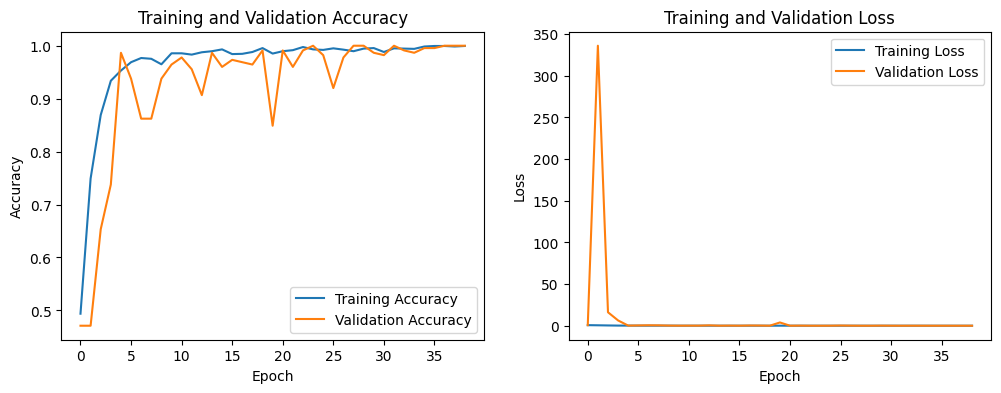

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       128
           1       0.98      0.99      0.98       122

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250

8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9788 - loss: 0.0590
[[125   3]
 [  1 121]]
Accuracy: 0.984
정확도: 0.9840


/kaggle/working/2xception_2500_history.txt

8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9788 - loss: 0.0590
compile_metrics
{'anthracnose': 0, 'healthy': 1}
Test Loss : 0.057745, Test Accuracy : 98.400%
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step
[[125   3]
 [  1 121]]


/kaggle/working/2xception_2500_history.txt

42
2056 2399
1250 1250
Found 2025 validated image filenames belonging to 2 classes.
Found 225 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Logs will be saved in: /kaggle/working/my_logs
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6666 - loss: 0.5720
Epoch 1: val_loss improved from inf to 34.73537, saving model to /kaggle/working/42xception_2500_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 294s 4s/step - accuracy: 0.6688 - loss: 0.5702 - val_accuracy: 0.4933 - val_loss: 34.7354 - learning_rate: 0.0010
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9416 - loss: 0.1775
Epoch 2: val_loss improved from 34.73537 to 8.56377, saving model to /kaggle/working/42xception_2500_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.9416 - loss: 0.1772 - val_accuracy: 0.6933 - val_loss: 8.5638 - learning_rate: 0.0010
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9531 - loss: 0.1049
Epoch 3: val_loss improved from 8.56377 to 5.01676, saving model to /kaggle/working/42xception_2500_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.9532 - loss: 0.1048 - val_accuracy: 0.8222 - val_loss: 5.0168 - learning_rate: 0.0010
Epoch

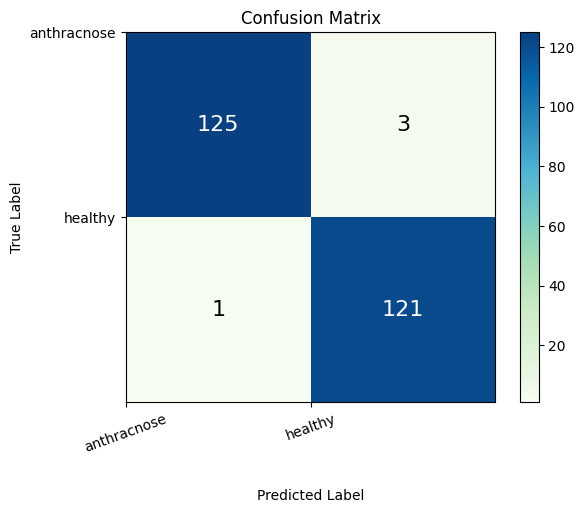

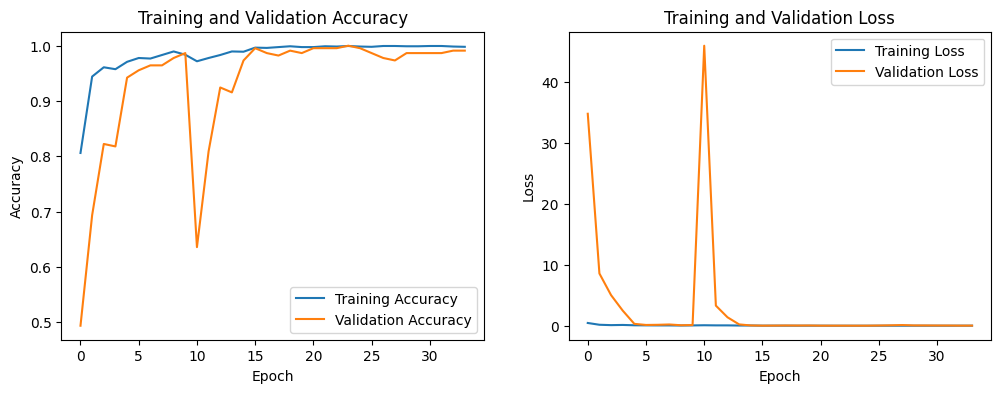

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       126
           1       0.99      0.98      0.99       124

    accuracy                           0.99       250
   macro avg       0.99      0.99      0.99       250
weighted avg       0.99      0.99      0.99       250

8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9861 - loss: 0.0332
[[125   1]
 [  2 122]]
Accuracy: 0.988
정확도: 0.9880


/kaggle/working/42xception_2500_history.txt

8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9861 - loss: 0.0332
compile_metrics
{'anthracnose': 0, 'healthy': 1}
Test Loss : 0.056483, Test Accuracy : 98.800%
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
[[125   1]
 [  2 122]]


/kaggle/working/42xception_2500_history.txt

123
2056 2399
1250 1250
Found 2025 validated image filenames belonging to 2 classes.
Found 225 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Logs will be saved in: /kaggle/working/my_logs
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5918 - loss: 0.6709
Epoch 1: val_loss improved from inf to 29.85262, saving model to /kaggle/working/123xception_2500_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.5932 - loss: 0.6701 - val_accuracy: 0.5378 - val_loss: 29.8526 - learning_rate: 0.0010
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7836 - loss: 0.4839
Epoch 2: val_loss improved from 29.85262 to 7.24752, saving model to /kaggle/working/123xception_2500_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.7842 - loss: 0.4831 - val_accuracy: 0.7111 - val_loss: 7.2475 - learning_rate: 0.0010
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8900 - loss: 0.2807
Epoch 3: val_loss did not improve from 7.24752
64/64 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.8904 - loss: 0.2798 - val_accuracy: 0.5867 - val_loss: 15.9168 - learning_rate: 0.0010
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.958

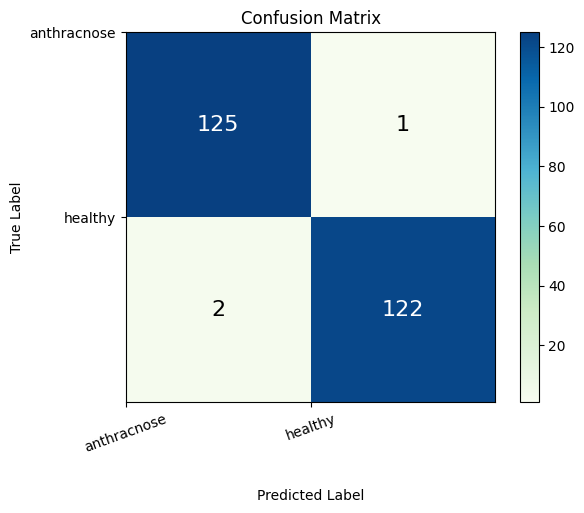

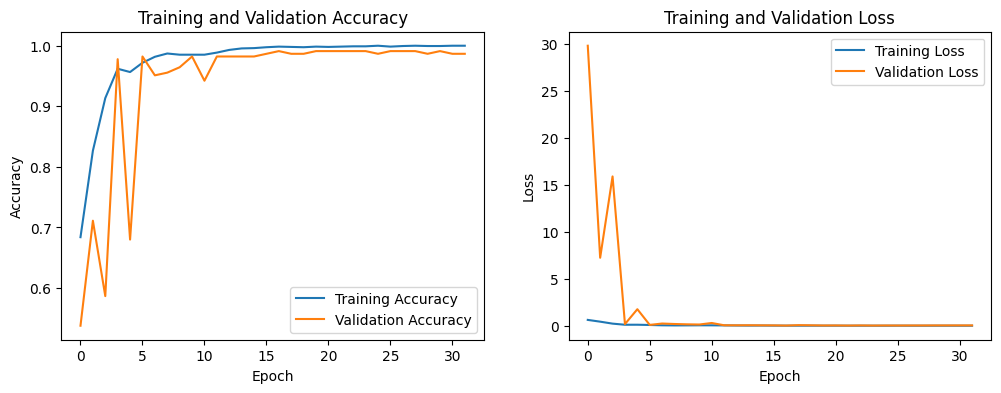

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       137
           1       0.97      1.00      0.99       113

    accuracy                           0.99       250
   macro avg       0.99      0.99      0.99       250
weighted avg       0.99      0.99      0.99       250

8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9898 - loss: 0.0481
[[134   3]
 [  0 113]]
Accuracy: 0.988
정확도: 0.9880


/kaggle/working/123xception_2500_history.txt

8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9898 - loss: 0.0481
compile_metrics
{'anthracnose': 0, 'healthy': 1}
Test Loss : 0.053227, Test Accuracy : 98.800%
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step
[[134   3]
 [  0 113]]


/kaggle/working/123xception_2500_history.txt

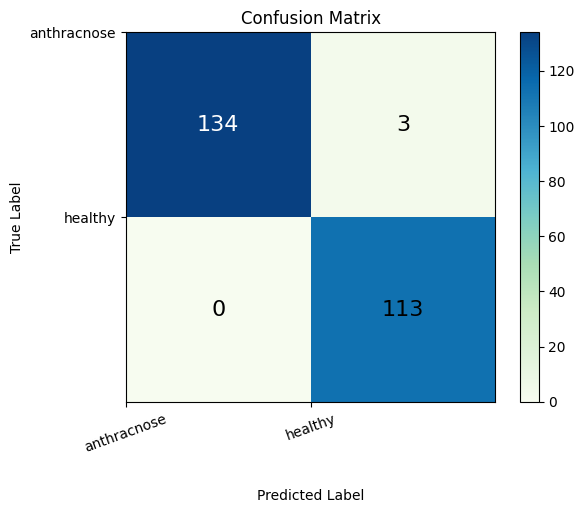

In [14]:
from IPython.display import FileLink
from IPython.core.magic import register_line_cell_magic
from io import StringIO
import sys

n = 2500
# half = 1500
model_name = 'xception_2500'
model_type = 'xception'

# List of random states
random_state_list = [2,42,123]

# Loop to train the model with different random states
for random_state in random_state_list:
    # Randomly sample 500 data points
    random_state=random_state
    np.random.seed(random_state)
    tf.random.set_seed(random_state) 
    print(random_state)
    fold_n = str(random_state)
    # data load
    train_dir='/kaggle/input/chili-pepper/Kaggle_upload'
    ds_health =glob.glob(train_dir + '/Healthy/*')
    ds_anth =glob.glob(train_dir + '/Anthracnose/*')
    print(len(ds_anth), len(ds_health))
    # set the number of data
    fold_ds_health = random.sample(ds_health, int(n/2))
    fold_ds_anth = random.sample(ds_anth, int(n/2))
    print(len(fold_ds_anth), len(fold_ds_health))

    train_path = fold_ds_health + fold_ds_anth
    train_label = ["healthy" for _ in range(len(fold_ds_health))] + ["anthracnose" for _ in range(len(fold_ds_anth))] # + ["bacterial_spot" for _ in range(len(ds_bs))] + ["PepMoV" for _ in range(len(ds_v))]
    sample_data = pd.DataFrame({"path":train_path, "label":train_label})

    # Assuming 'image_path' and 'label' columns exist in the dataframe
    train_df, test_df = train_test_split(sample_data, test_size=0.1, random_state=random_state)
    train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=random_state)

    train_gen_iter, valid_gen_iter,test_gen_iter  = create_data_generators(train_df=train_df,valid_df=valid_df,test_df=test_df,batch_size=BATCH_SIZE,image_size=IMAGE_SIZE)
    
    output_path = f'{dir}{random_state}{model_name}_output.txt'


    # Train the model
    model, history = train_model_random_sample(model_name, model_type, image_size=IMAGE_SIZE,
                                 train=train_gen_iter,valid=valid_gen_iter, random_state=str(random_state))
 

    # Save the training history to a text file
    history_path = f'{dir}{random_state}{model_name}_history.txt'
    with open(history_path, 'w') as f:
        for key, values in history.history.items():
            f.write(f"{key}: {values}\n")
            
     # Training visualization
    plot_metrics(history,model_name,fold=fold_n)

    # classification report
    generate_classification_report(model=model,name=model_name,fold=fold_n)
    display(FileLink(history_path))
    
    scores = model.evaluate(test_gen_iter) 
    print(f'{model.metrics_names [1]}')
    print(test_gen_iter.class_indices)
    print('Test Loss : {:.6f}, Test Accuracy : {:.3f}%'. format (scores [0], scores [1]*100))
  

    # confusion matrix
    generate_confusion_matrix(model=model,name=model_name,fold=fold_n)
    display(FileLink(history_path))
    

# Hold out validation with best model

In [23]:
test_dir='/home/nanopore/pepper/Kaggle_upload(chili-pepper)-seperated/test'
t_health =glob.glob(test_dir + '/Healthy/*')
t_anth =glob.glob(test_dir + '/Anthracnose/*')
print(len(t_health))
print(len(t_anth))

240

206


In [13]:
e_test_dir='/home/nanopore/pepper/Kaggle_upload(chili-pepper)-seperated/early-test'
et_health =glob.glob(e_test_dir + '/healthy/*')
et_anth =glob.glob(e_test_dir + '/anthracnose/*')
print(len(et_health))
print(len(et_anth))

50

50


In [24]:
test_path = t_health + t_anth
test_label = ["Healthy" for _ in range(len(t_health))] + ["Anthracnose" for _ in range(len(t_anth))] # + ["bacterial_spot" for _ in range(len(ds_bs))] + ["PepMoV" for _ in range(len(ds_v))]
test_df = pd.DataFrame({"path":test_path, "label":test_label})


In [14]:
etest_path = et_health + et_anth
etest_label = ["Healthy" for _ in range(len(et_health))] + ["Anthracnose" for _ in range(len(et_anth))] # + ["bacterial_spot" for _ in range(len(ds_bs))] + ["PepMoV" for _ in range(len(ds_v))]
etest_df = pd.DataFrame({"path":etest_path, "label":etest_label})

In [25]:
image_size = 224
batch_size = 32
# Define the ImageDataGenerator with only rescaling for test data
test_generator = ImageDataGenerator(rescale=1/255.0)

# Flow from DataFrame using test_generator for test data
test_generator_iterator = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(image_size, image_size),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False)
test_batch, test_label_batch = next(test_generator_iterator)

Found 446 validated image filenames belonging to 2 classes.


In [15]:
image_size = 224
batch_size = 32
# Define the ImageDataGenerator with only rescaling for test data
etest_generator = ImageDataGenerator(rescale=1/255.0)

# Flow from DataFrame using test_generator for test data
etest_generator_iterator = etest_generator.flow_from_dataframe(
    dataframe=etest_df,
    x_col='path',
    y_col='label',
    target_size=(image_size, image_size),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False)
etest_batch, etest_label_batch = next(etest_generator_iterator)

Found 100 validated image filenames belonging to 2 classes.


## Load model

In [31]:
from tensorflow.keras.models import load_model

model_path = '/home/nanopore/pepper/models/MobileNet/3000/2mobilenet_3000_model.keras'
model = load_model(model_path)
name = '/home/nanopore/pepper/models/MobileNet/3000/test_2mobilenet_3000'
ename='/home/nanopore/pepper/models/MobileNet/3000/etest_2mobilenet_3000'

## Classification Report

In [32]:
#fixed with wrtn
import csv
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

def generate_classification_report(model,data_df,data_gen, name):
    # Create a LabelBinarizer object
    lb = LabelBinarizer()

    # Fit the label binarizer to the label column
    lb.fit(data_df['label'])

    # Transform the label column to binary list
    label_list = lb.transform(data_df['label']).tolist()

    # Flatten the list of ground truth labels and convert to numpy array
    true_labels = np.ravel(label_list)

    predicted_labels = model.predict(data_gen)
    predicted_labels = np.argmax(predicted_labels, axis=1)  # 모델의 출력을 가장 높은 확률을 가진 클래스로 변환
    # Get classification report (including F1 score, precision, and recall)
    report = classification_report(true_labels, predicted_labels)
    
    print(report)    
    
    with open(name+'_report.csv', 'w') as file:
        writer = csv.writer(file)
        for line in report.split('\n'):
            writer.writerow(line.split(','))
        
        evaluation_results = model.evaluate(data_gen)
        evaluation_results_header = ['Metric', 'Value']
 
        # 정확도(accuracy)를 계산합니다.
        sk_accuracy = accuracy_score(true_labels, predicted_labels)

        #confusion matrix 계산
        cm = confusion_matrix(true_labels, predicted_labels)
        print(cm)

        tn, fp, fn, tp = cm.ravel()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (precision * recall) / (precision + recall)
        accuracy = (tp+tn) / (tp+fp+fn+tn)

        print('Accuracy:', accuracy)
        writer.writerow(['tp',tp])
        writer.writerow(["fp",fp])
        writer.writerow(["fn",fn])
        writer.writerow(['tn',tn])
        writer.writerow(["precision", precision])
        writer.writerow(["recall",recall])
        writer.writerow(['f1score',f1_score])
        writer.writerow(['accuracy',accuracy])
        writer.writerow(['Loss', evaluation_results[0]])
        writer.writerow(['Accuracy', evaluation_results[1]])


        # 결과를 출력합니다.
        print("정확도: {:.4f}".format(sk_accuracy))

        class_names = list(data_gen.class_indices.keys())
    
    # Plot the confusion matrix
    plt.imshow(cm, cmap=plt.cm.GnBu, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))-0.5
    plt.xticks(tick_marks, class_names, rotation=20)
    plt.yticks(tick_marks, class_names)
    
    plt.xlabel('Predicted Label', labelpad=25)
    plt.ylabel('True Label')

    thresh = cm.max()-20
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i,j], "d"), ha="center", va="center",
                    color="white" if cm[i,j] > thresh else "black", fontsize=16)

     # Save the figure as a JPG image
    plt.savefig(name +'_confusion_matrix.jpg', dpi=200,bbox_inches='tight')


/home/nanopore/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

  if is_sparse(pd_dtype):

/home/nanopore/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):

/home/nanopore/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

  if is_sparse(pd_dtype):

/home/nanopore/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance

14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step

              precision    recall  f1-score   support



           0       0.98      0.97      0.97       206

           1       0.97      0.98      0.98       240



    accuracy                           0.98       446

   macro avg       0.98      0.97      0.98       446

weighted avg       0.98      0.98      0.98       446



14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9833 - loss: 0.0551

[[199   7]

 [  4 236]]

Accuracy: 0.9753363228699552

정확도: 0.9753


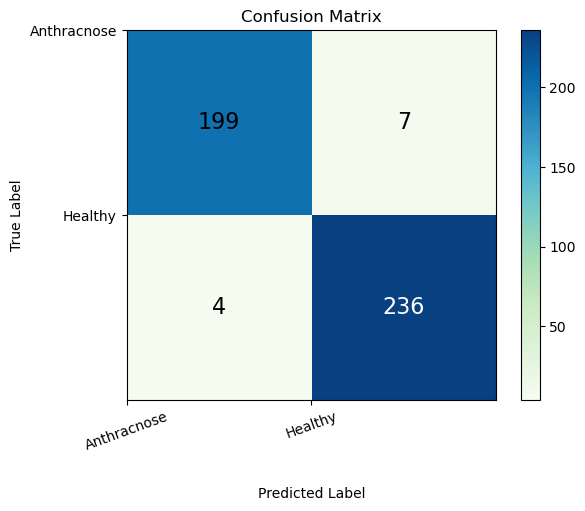

In [33]:
generate_classification_report(model=model,data_df=test_df,data_gen=test_generator_iterator,name=name)

/home/nanopore/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

  if is_sparse(pd_dtype):

/home/nanopore/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):

/home/nanopore/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

  if is_sparse(pd_dtype):

/home/nanopore/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step

              precision    recall  f1-score   support



           0       0.79      0.90      0.84        50

           1       0.88      0.76      0.82        50



    accuracy                           0.83       100

   macro avg       0.84      0.83      0.83       100

weighted avg       0.84      0.83      0.83       100



4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7893 - loss: 0.7626

[[45  5]

 [12 38]]

Accuracy: 0.83

정확도: 0.8300


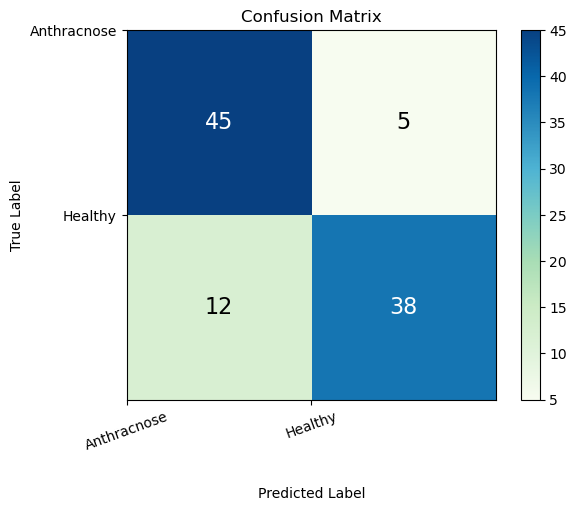

In [34]:

generate_classification_report(model=model,data_df=etest_df,data_gen=etest_generator_iterator,name=ename)

## Confusion matrix

In [71]:
# Define confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

def generate_confusion_matrix(model,name):
    lb = LabelBinarizer()

    # Fit the label binarizer to the label column
    lb.fit(test_df['label'])

    # Transform the label column to binary list
    label_list = lb.transform(test_df['label']).tolist()

    # Flatten the list of ground truth labels and convert to numpy array
    true_labels = np.ravel(label_list)

    predicted_labels = model.predict(test_generator_iterator)
    predicted_labels = np.argmax(predicted_labels, axis=1) 

    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)
    class_names = list(test_generator_iterator.class_indices.keys())
    
    # Plot the confusion matrix
    plt.imshow(cm, cmap=plt.cm.GnBu, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))-0.5
    plt.xticks(tick_marks, class_names, rotation=20)
    plt.yticks(tick_marks, class_names)
    
    plt.xlabel('Predicted Label', labelpad=25)
    plt.ylabel('True Label')

    thresh = cm.max()-20
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i,j], "d"), ha="center", va="center",
                    color="white" if cm[i,j] > thresh else "black", fontsize=16)

     # Save the figure as a JPG image
    plt.savefig(name +'_confusion_matrix.jpg', dpi=200,bbox_inches='tight')


14/14 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step

[[196  10]

 [  8 232]]


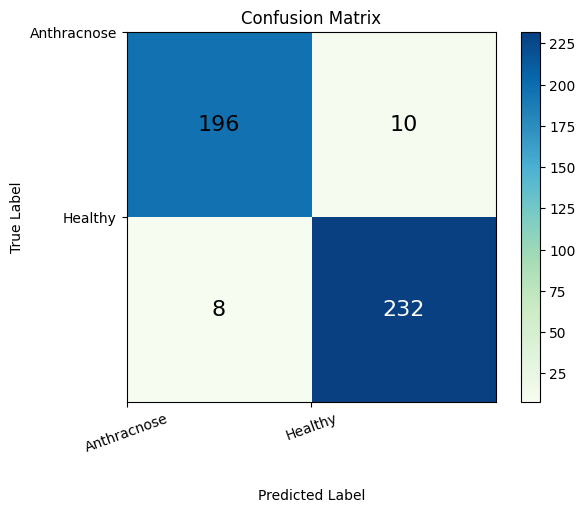

In [72]:
generate_confusion_matrix(model=model,name=name)

## t-SNE visualization

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def tsne_v(model,name, data):
    def extract_features(model, data):
        # 주어진 모델의 입력과 'global_average_pooling2d' 레이어의 출력을 연결하는 모델, 이를 통해 모델의 특성을 추출
        feature_extractor = Model(inputs=model.input, outputs=model.get_layer('global_average_pooling2d').output)
        features = feature_extractor.predict(data)
        return features

    # 모델과 데이터로부터 특성 추출
    features = extract_features(model,test_generator_iterator)
    # TSNE를 사용하여 2차원으로 차원 축소
    tsne = TSNE(n_components=2,perplexity=5).fit_transform(features)
    # 시각화할 데이터 포인트의 색상과 레이블 설정
    colors_per_class = {
    #     'bacterial_spot': 'red',
    #     'powdery_mildew' : 'green',
    #     'PepMoV': 'purple',
        'Anthracnose' : 'red',
        'Healthy': 'blue'
    }

    # 시각화할 데이터 포인트의 색상 저장하는 리스트 초기화
    scatter_colors = []

    # test_df의 각 데이터 포인트에 대해 색상을 저장
    for _, data_point in test_df.iterrows():
        color = colors_per_class[data_point['label']]
        scatter_colors.append(color)

    # 산점도 그리기
    plt.scatter(tsne[:, 0], tsne[:, 1], c=scatter_colors)

    # 그래프 제목 설정
    plt.title("t-SNE Visualization")

    # x축, y축 레이블 설정
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")

    # 범례 항목 생성
    legend_patches = [mpatches.Patch(color=color, label=label) for label, color in colors_per_class.items()]

    # 범례 표시
    plt.legend(handles=legend_patches)

    # 그래프 출력
    plt.savefig(name+'_t-sne.png',dpi=200)
    plt.show()
    

## PCA Visualization

In [32]:

def pca_v(model, name, data):
    def extract_features(model, data):
        # 주어진 모델의 입력과 'global_average_pooling2d' 레이어의 출력을 연결하는 모델, 이를 통해 모델의 특성을 추출
        feature_extractor = Model(inputs=model.input, outputs=model.get_layer('global_average_pooling2d').output)
        features = feature_extractor.predict(data)
        return features
    
    # 모델과 데이터로부터 특성 추출
    features = extract_features(model,data)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    # 시각화할 데이터 포인트의 색상과 레이블 설정
    colors_per_class = {
        #     'bacterial_spot': 'red',
        #     'powdery_mildew' : 'green',
        #     'PepMoV': 'purple',
        'Anthracnose' : 'red',
        'Healthy': 'blue'}
    # 시각화할 데이터 포인트의 색상 저장하는 리스트 초기화
    scatter_colors = []
    # test_df의 각 데이터 포인트에 대해 색상을 저장
    for _, data_point in test_df.iterrows():
        color = colors_per_class[data_point['label']]
        scatter_colors.append(color)
        
    
    # 산점도 그리기
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=scatter_colors)

    # 그래프 제목 설정
    plt.title("PCA Visualization")

    # x축, y축 레이블 설정
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")

    # 범례 항목 생성
    legend_patches = [mpatches.Patch(color=color, label=label) for label, color in colors_per_class.items()]

    # 범례 표시
    plt.legend(handles=legend_patches)

    # 그래프 출력
    plt.savefig(name+'_pca.png',dpi=200)
    plt.show()
        


2024-05-25 15:35:45.656882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32

	 [[{{node Placeholder/_0}}]]


14/14 [==============================] - 26s 2s/step


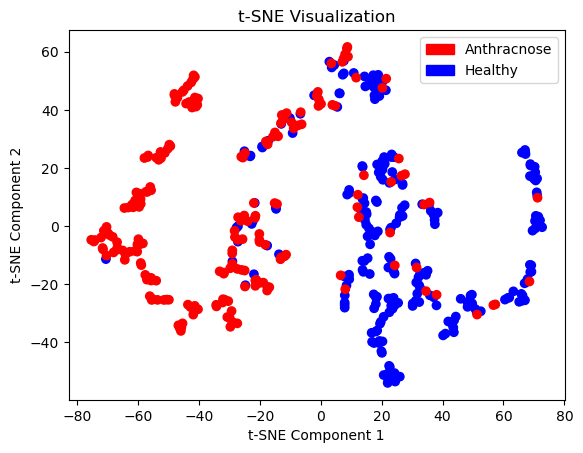

2024-05-25 15:36:14.528466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32

	 [[{{node Placeholder/_0}}]]


14/14 [==============================] - 26s 2s/step


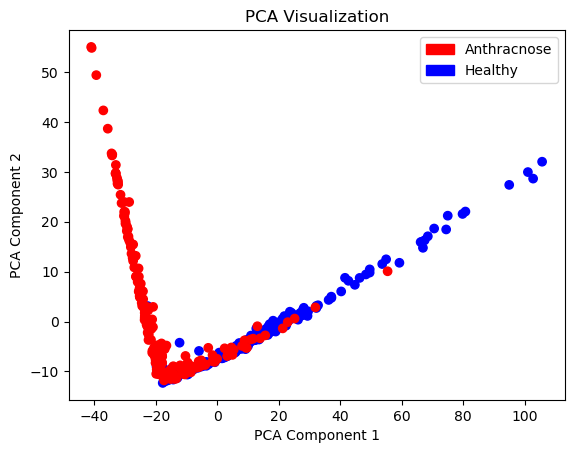

In [22]:
data = test_generator_iterator
tsne_v(model,name, data)
pca_v(model, name, data)

## CAM heatmap

/tmp/ipykernel_3239911/2096013932.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

  jet = cm.get_cmap("jet")


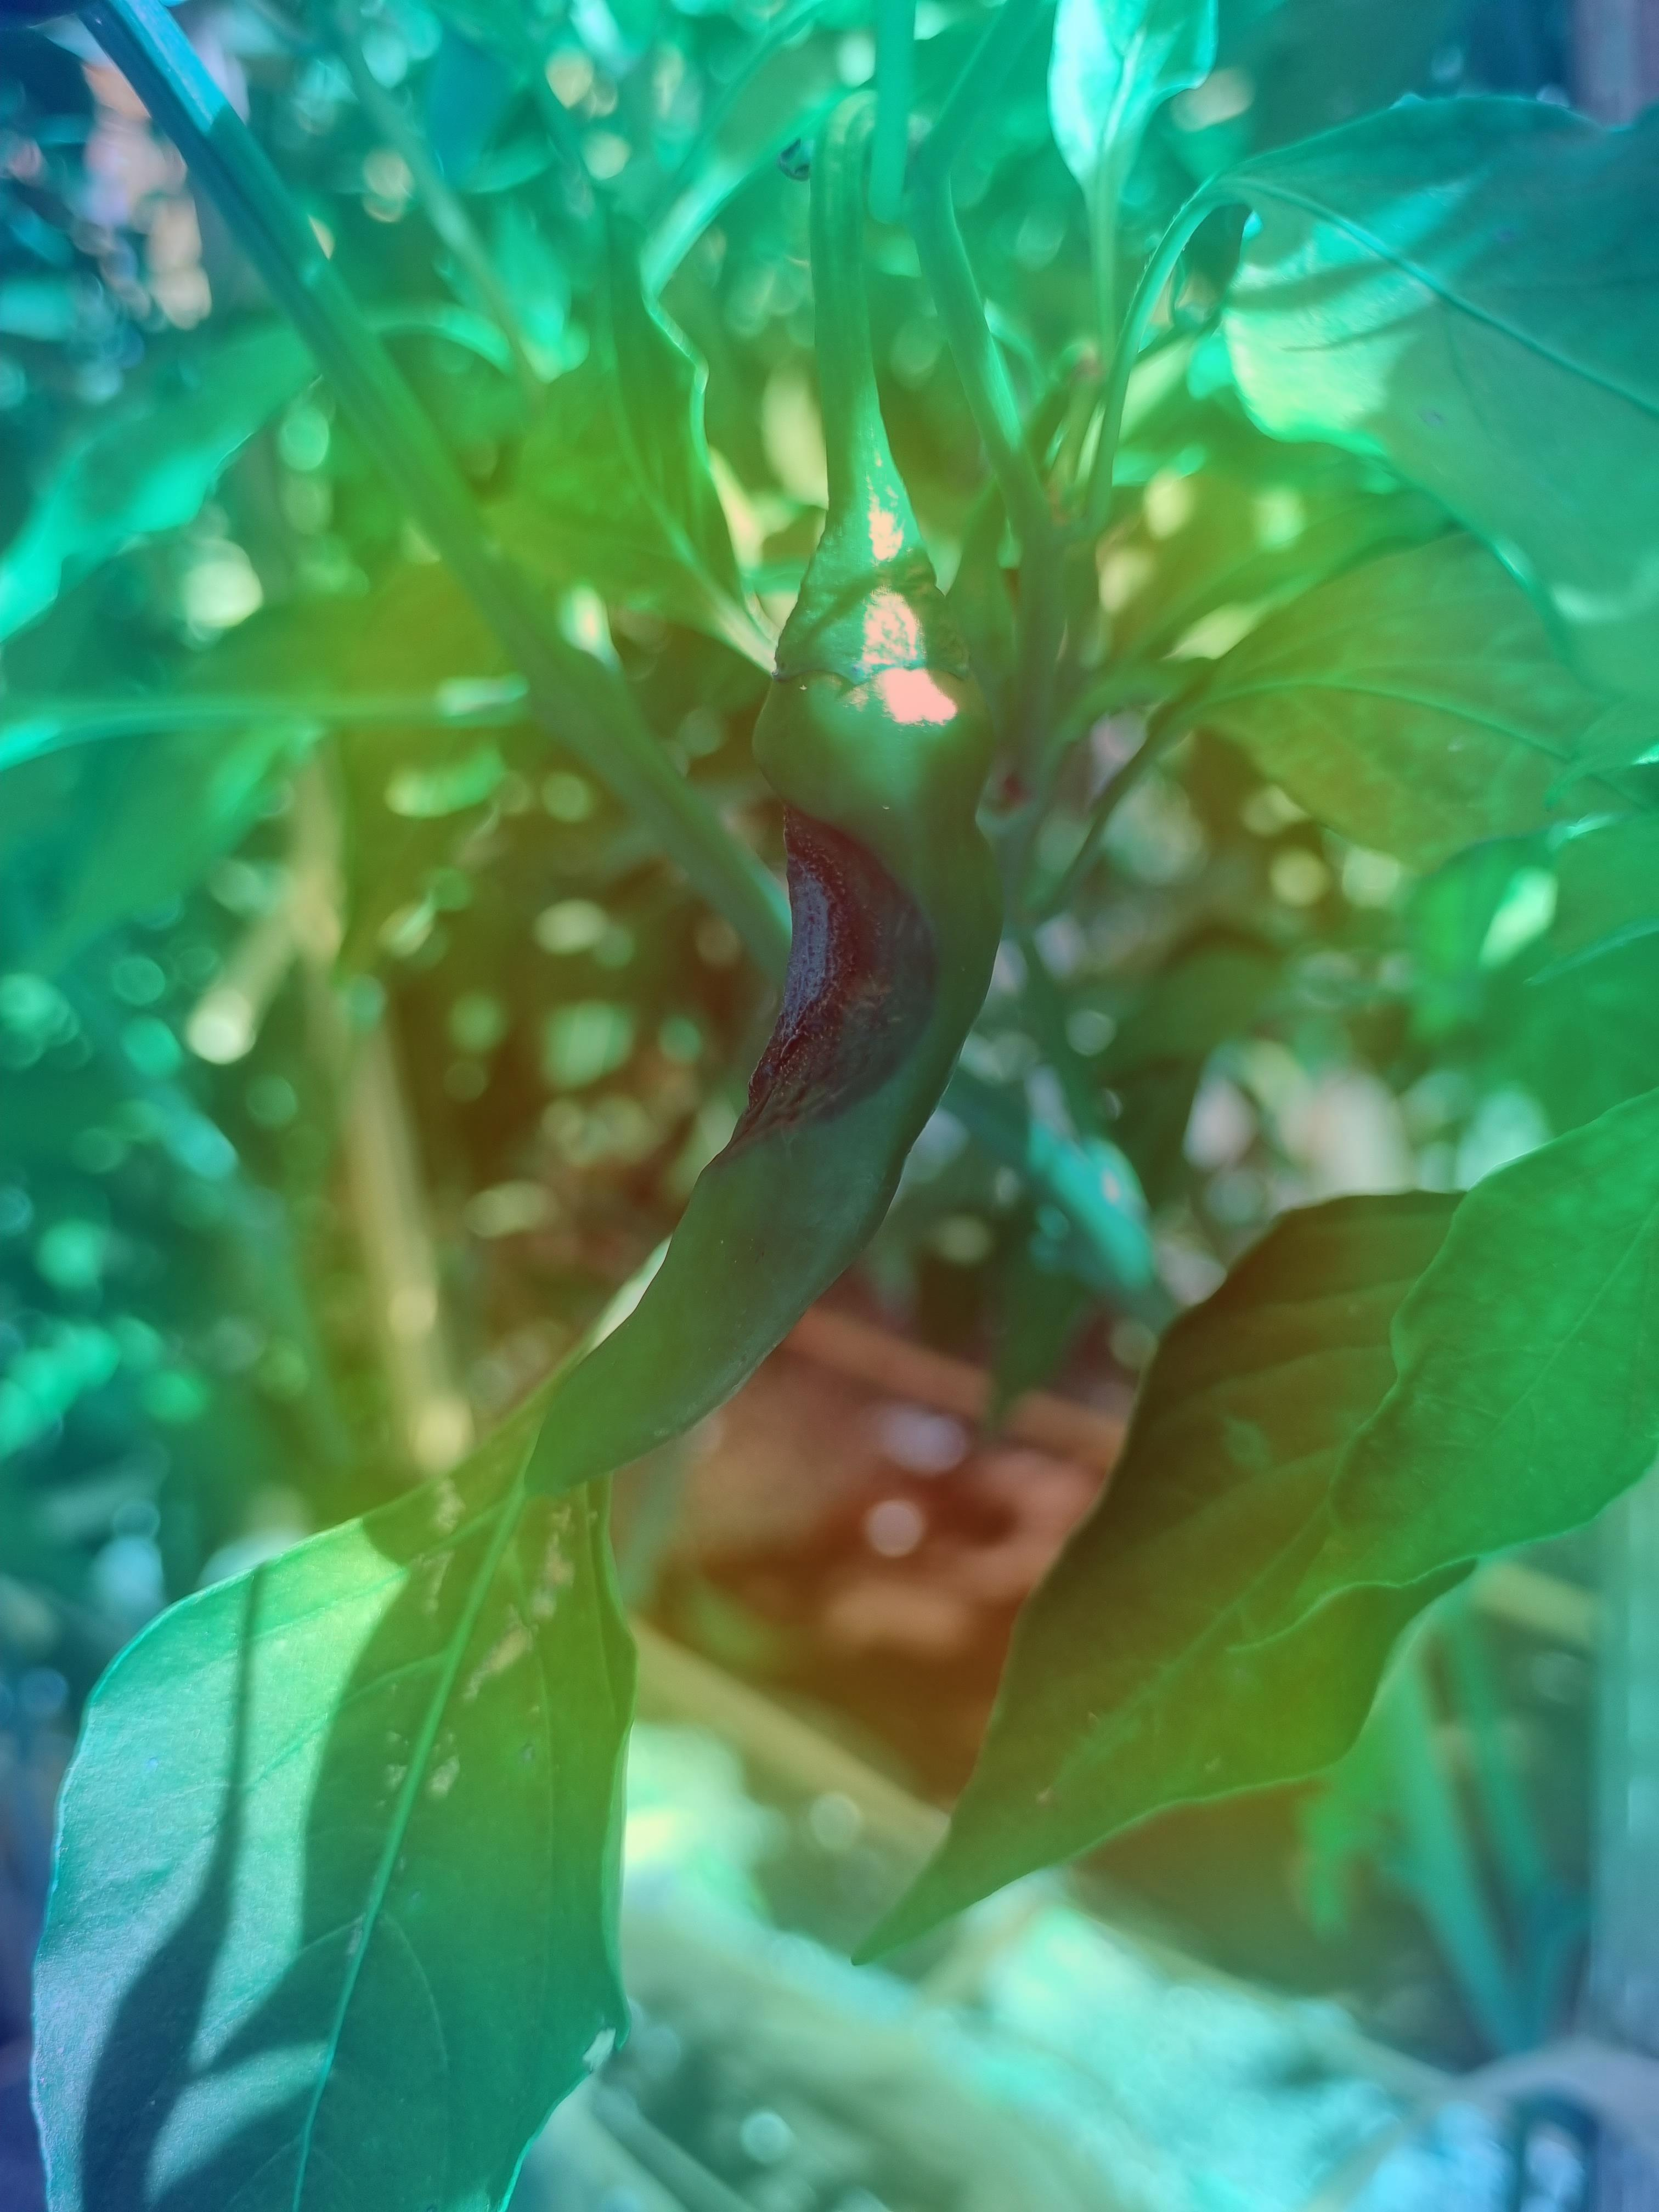

In [24]:
#xception

import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import Image

def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224 or any other
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path=name+"_cam.jpg", alpha=0.4):
    # Load the original image
    img = cv2.imread(img_path)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

# # Load the pre-trained Xception model
# model = tf.keras.applications.Xception(weights="imagenet")

# Remove the last layer's softmax
model.layers[-1].activation = None

# Prepare image
img_path = '/home/nanopore/pepper/Kaggle_upload(chili-pepper)-seperated/test/Anthracnose/20220826_102457.jpg'
img_array = get_img_array(img_path, size=(224,224))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, 'block14_sepconv2_act', ['global_average_pooling2d','dense', 'dropout', 'dense_1'])

# Save and display the grad CAM
save_and_display_gradcam(img_path, heatmap)


/tmp/ipykernel_34/3764103518.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

  jet = cm.get_cmap("jet")


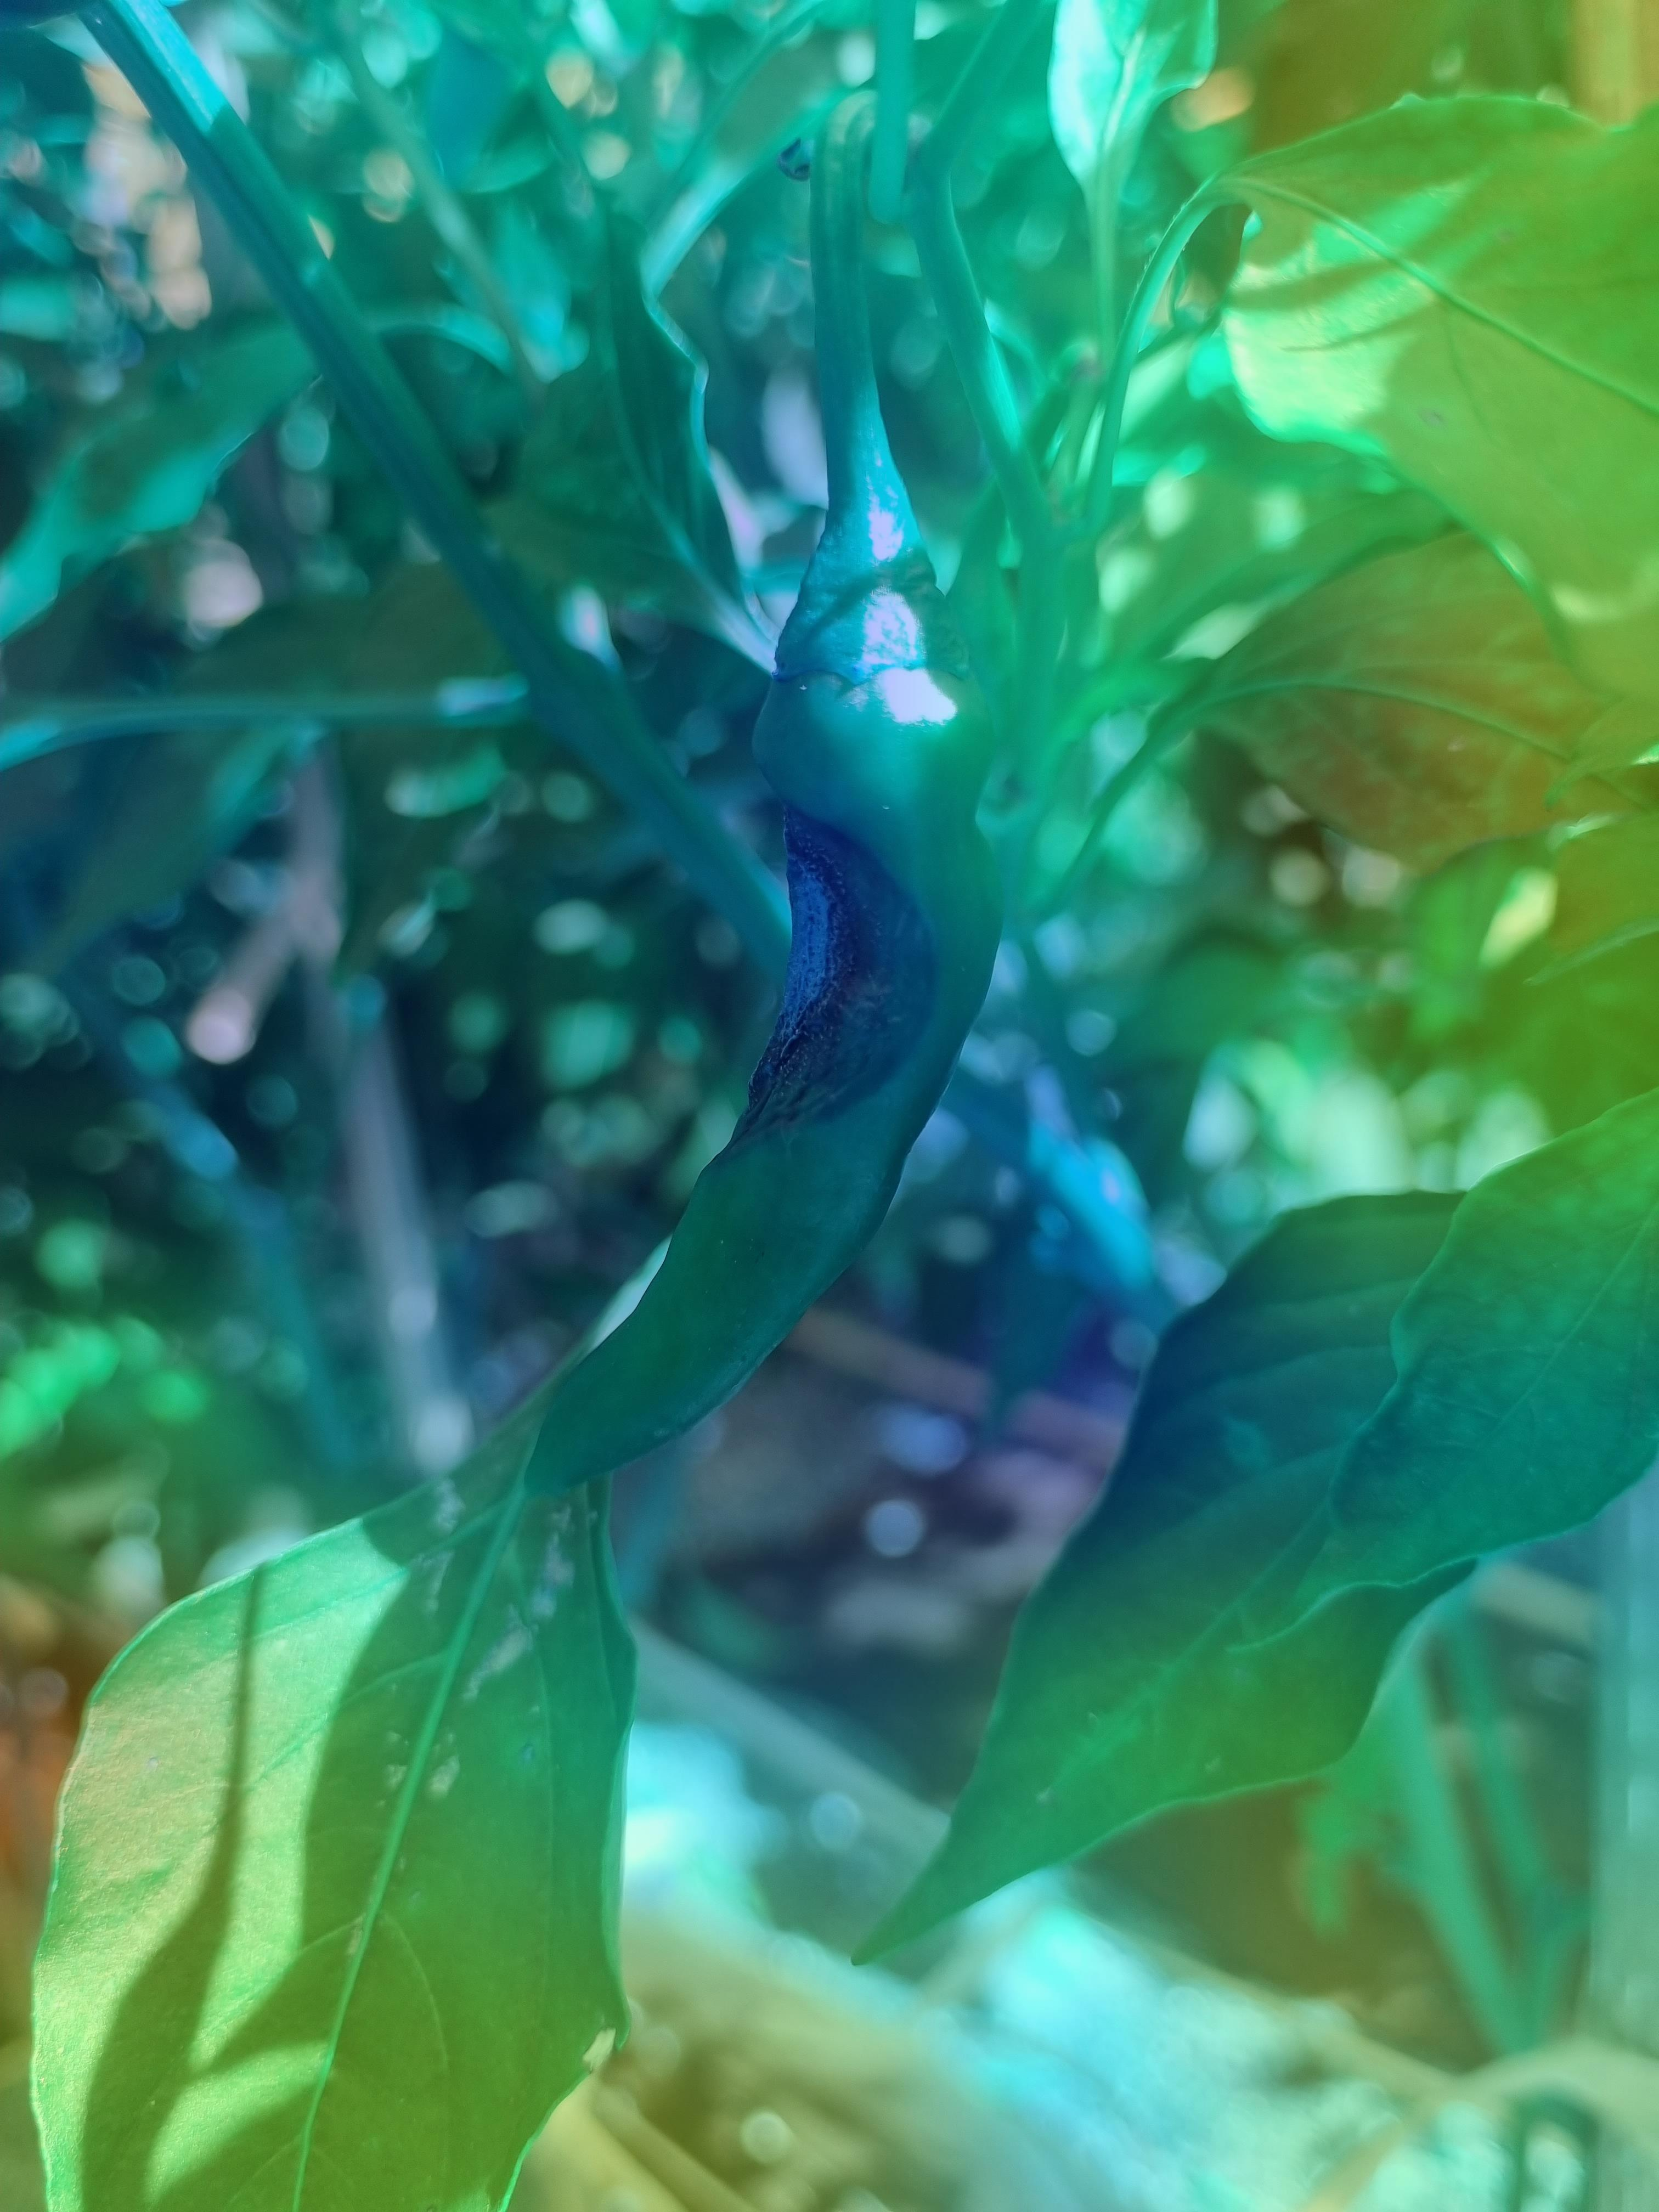

In [86]:
#MoblieNEt

import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import Image

def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224 or any other
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="/kaggle/working/"+name+"_cam.jpg", alpha=0.4):
    # Load the original image
    img = cv2.imread(img_path)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

# # Load the pre-trained Xception model
# model = tf.keras.applications.Xception(weights="imagenet")

# Remove the last layer's softmax
model.layers[-1].activation = None

# Prepare image
img_path = '/kaggle/input/separate-test/test/Anthracnose/20220826_102457.jpg'
img_array = get_img_array(img_path, size=(224,224))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, 'conv_pw_13_relu', ['global_average_pooling2d','dense', 'dropout', 'dense_1'])

# Save and display the grad CAM
save_and_display_gradcam(img_path, heatmap)


/tmp/ipykernel_1788052/455365954.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

  jet = cm.get_cmap("jet")


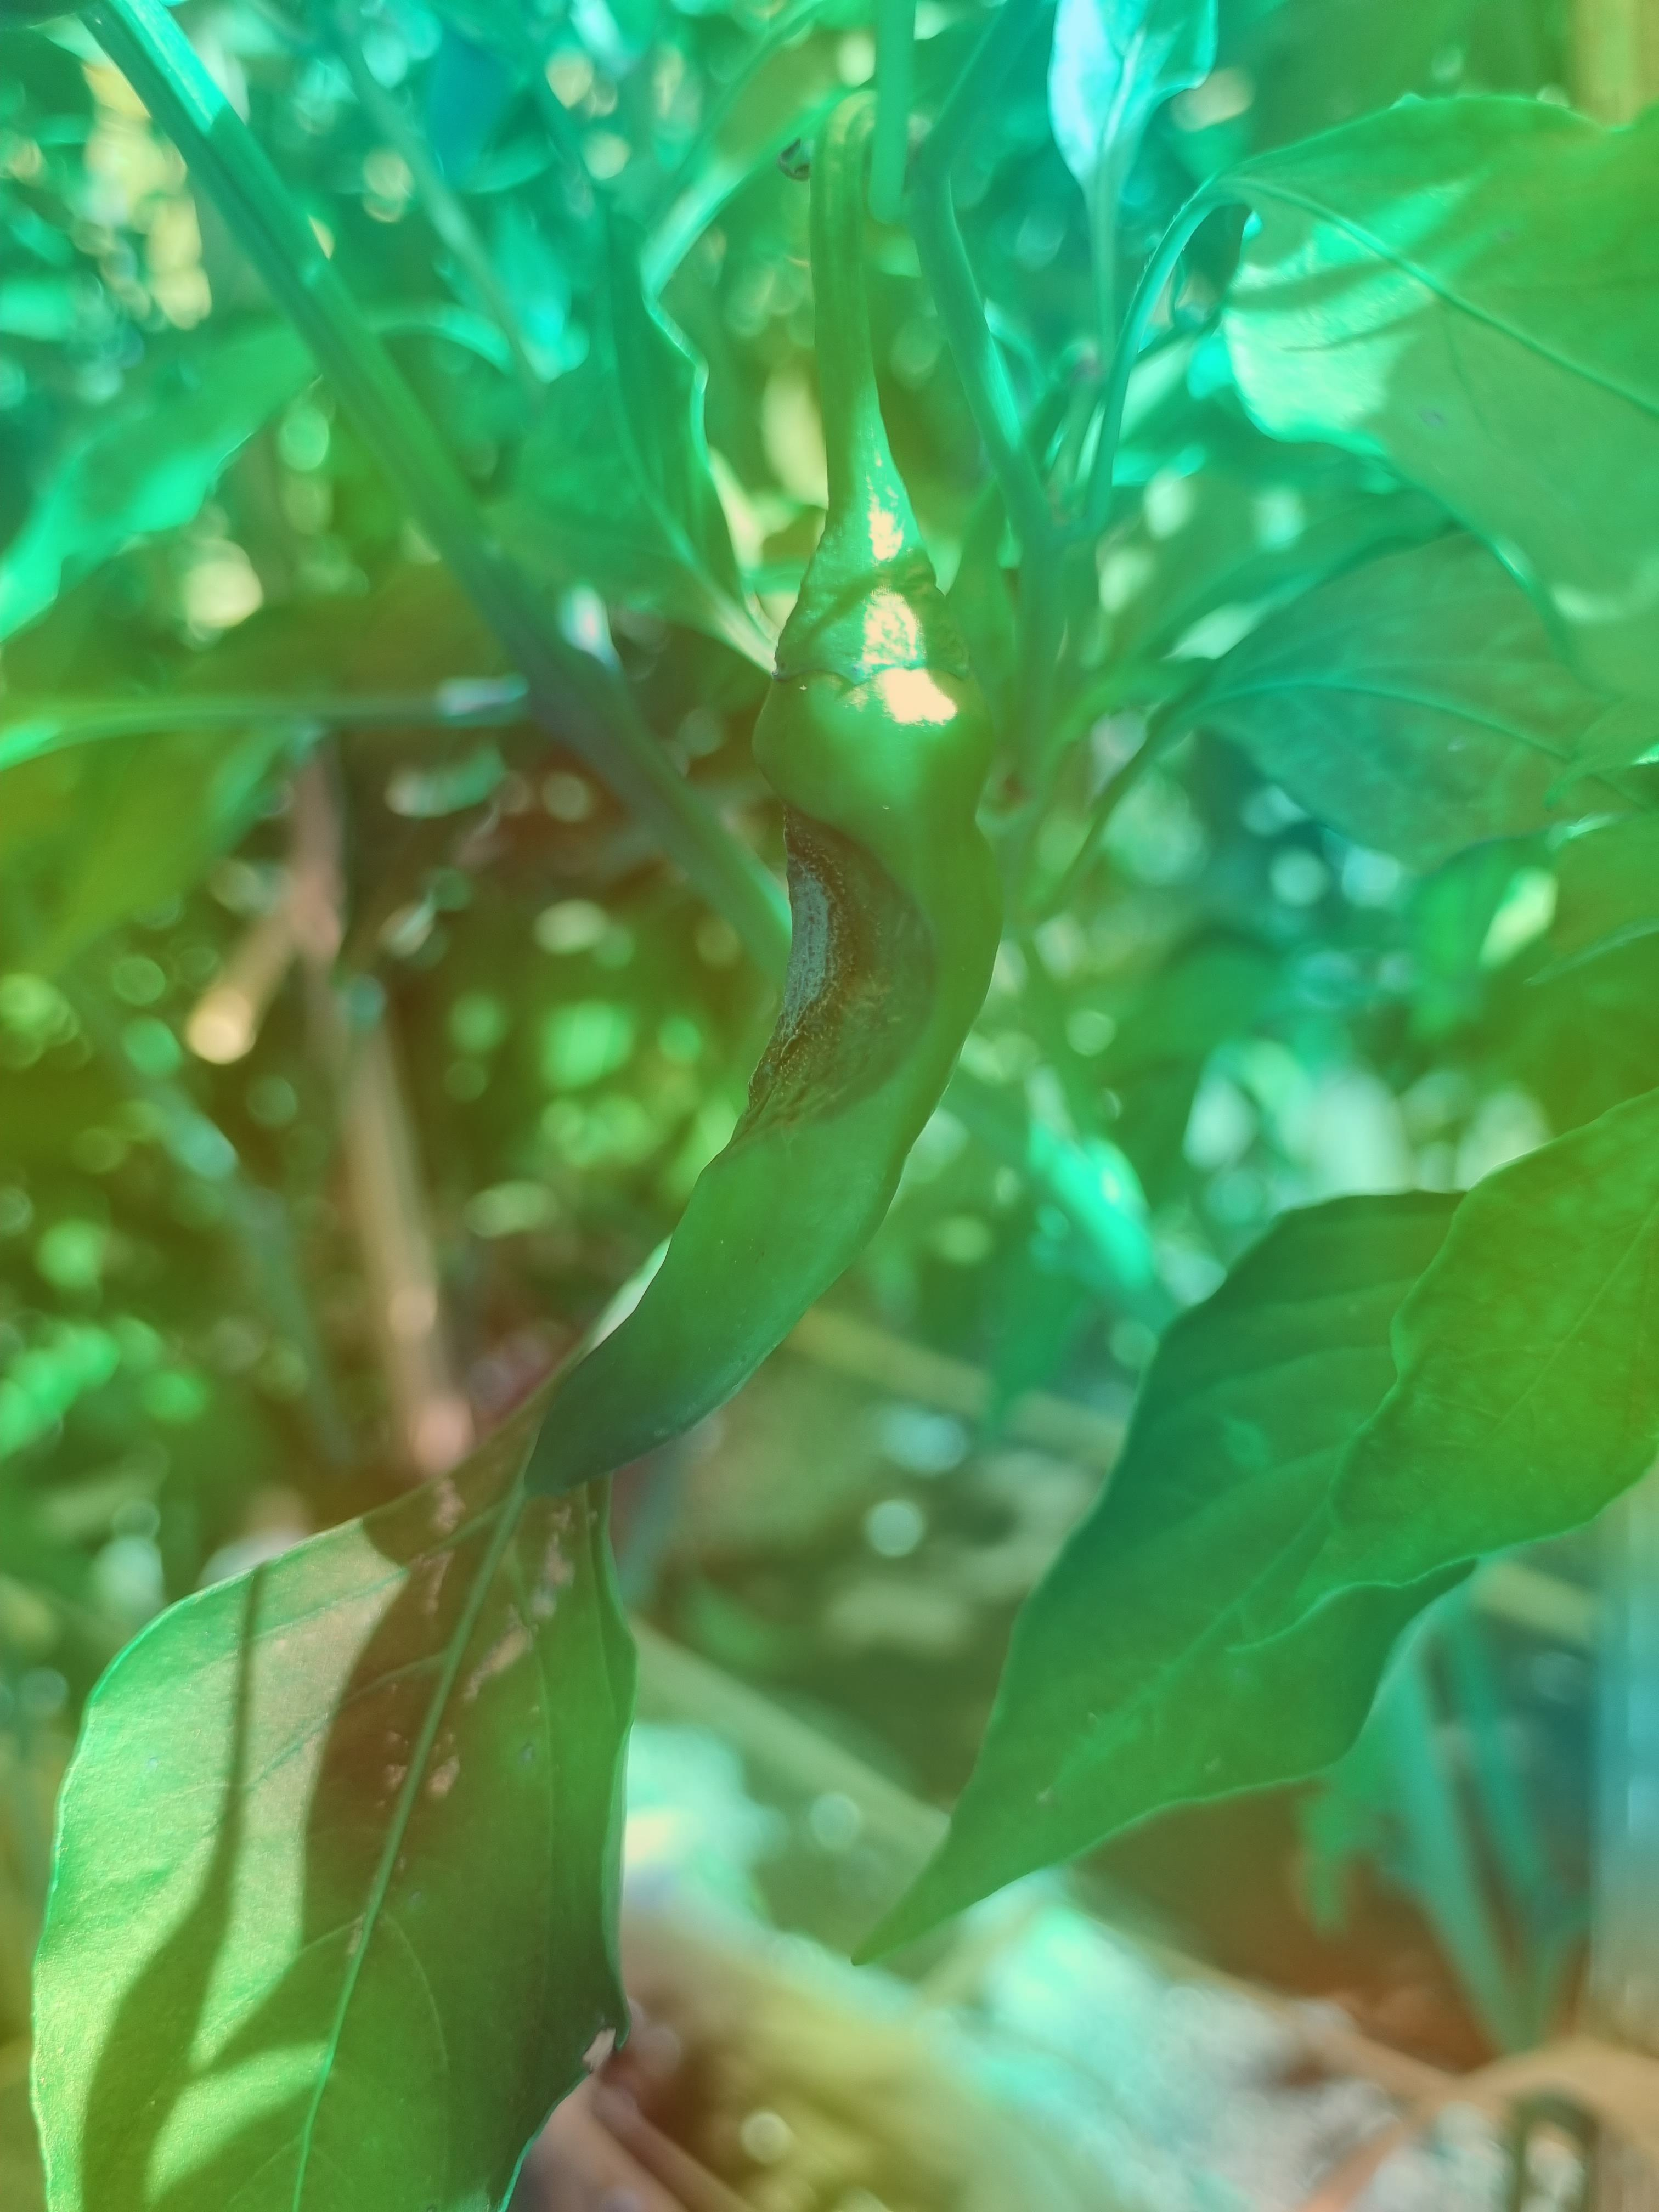

In [49]:
#MoblieNEt

import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import Image

def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224 or any other
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path=name+"_cam.jpg", alpha=0.4):
    # Load the original image
    img = cv2.imread(img_path)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

# # Load the pre-trained Xception model
# model = tf.keras.applications.Xception(weights="imagenet")

# Remove the last layer's softmax
model.layers[-1].activation = None

# Prepare image
img_path = '/home/nanopore/pepper/Kaggle_upload(chili-pepper)-seperated/test/Anthracnose/20220826_102457.jpg'
img_array = get_img_array(img_path, size=(224,224))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model,  'post_relu', ['global_average_pooling2d','dense', 'dropout', 'dense_1'])

# Save and display the grad CAM
save_and_display_gradcam(img_path, heatmap)
